<a href="https://colab.research.google.com/github/astrapi69/DroidBallet/blob/master/NLP_D1_2_LC8_Applications_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><a target="_blank" href="https://learning.constructor.org/"><img src="https://drive.google.com/uc?id=1RNy-ds7KWXFs7YheGo9OQwO3OnpvRSU1" width="200" style="background:none; border:none; box-shadow:none;" /></a> </center>

_____

<center>Constructor Academy, 2024</center>

# Topic Modeling on Research Papers

We will do an interesting exercise here—build topic models on past research papers
from the very popular NIPS conference (now known as the NeurIPS conference). The
late professor Sam Roweis compiled an excellent collection of NIPS Conference Papers
from Volume 1 – 12, which you can find at https://cs.nyu.edu/~roweis/data.html.
An interesting fact is that he obtained this by massaging the OCR’d data from NIPS
1-12, which was actually the pre-electronic submission era. Yann LeCun made the data
available. There is an even more updated dataset available up to NIPS 17 at http://
ai.stanford.edu/~gal/data.html. However, that dataset is in the form of a MAT file, so
you might need to do some additional preprocessing before working on it in Python.


## The Main Objective

Considering our discussion so far, our main objective is pretty simple. Given a whole
bunch of conference research papers, can we identify some key themes or topics from
these papers by leveraging unsupervised learning? We do not have the liberty of labeled
categories telling us what the major themes of every research paper are. Besides that, we
are dealing with text data extracted using OCR (optical character recognition). Hence,
you can expect misspelled words, words with characters missing, and so on, which
makes our problem even more challenging

## Download Data and Dependencies

In [ ]:
!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
!tar -xzf nips12raw_str602.tgz

--2024-03-23 20:10:25--  https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
Resolving cs.nyu.edu (cs.nyu.edu)... 216.165.22.203
Connecting to cs.nyu.edu (cs.nyu.edu)|216.165.22.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12851423 (12M) [application/x-gzip]
Saving to: ‘nips12raw_str602.tgz’

nips12raw_str602.tg 100%[===================>]  12.26M  23.3MB/s    in 0.5s    

2024-03-23 20:10:26 (23.3 MB/s) - ‘nips12raw_str602.tgz’ saved [12851423/12851423]



In [ ]:
!pip install tqdm
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import os
import numpy as np
import pandas as pd

DATA_PATH = 'nipstxt/'
print(os.listdir(DATA_PATH))

['nips11', 'nips09', 'idx', 'nips02', 'nips05', 'nips10', 'README_yann', 'nips12', 'nips06', 'MATLAB_NOTES', 'nips01', 'orig', 'nips07', 'nips00', 'nips04', 'nips03', 'RAW_DATA_NOTES', 'nips08']


## Load NIPS Research Papers Data



In [ ]:
folders = ["nips{0:02}".format(i) for i in range(0,13)]
# Read all texts into a list.
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + folder)
    for file_name in file_names:
        with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
            data = f.read()
        papers.append(data)
len(papers)

1740

In [ ]:
print(papers[3][:1000])

674 
PATYEP CLASS DEGENERACY IN AN UNRESTRICTED STORAGE 
DENSITY MEMORY 
Christopher L. Scofield, Douglas L. Reilly, 
Charles Elbaum, Leon N. Cooper 
Nestor, Inc., 1 Richmond Square, Providence, Rhode Island, 
02906. 
ABSTRACT 
The study of distributed memory systems has produced a 
number of models which work well in limited domains. 
However, until recently, the application of such systems to real- 
world problems has been difficult because of storage limitations, 
and their inherent architectural (and for serial simulation, 
computational) complexity. Recent development of memories 
with unrestricted storage capacity and economical feedforward 
architectures has opened the way to the application of such 
systems to complex pattern recognition problems. However, 
such problems are sometimes underspecified by the features 
which describe the environment, and thus a significant portion 
of the pattern environment is often non-separable. We will 
review current work on high density memo

## Basic Text Pre-processing

We perform some basic text wrangling or preprocessing before diving into topic
modeling. We keep things simple here

In [ ]:
%%time
import nltk
import tqdm

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+') # can also use nltk.word_tokenize to get word tokens for each paper
wnl = nltk.stem.wordnet.WordNetLemmatizer() # can use spacy lemmatization also

def normalize_corpus(papers):
    norm_papers = []
    for paper in tqdm.tqdm(papers):
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1] # removing any single character words \ numbers \ symbols
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)

    return norm_papers

norm_papers = normalize_corpus(papers)
print(len(norm_papers))

100%|██████████| 1740/1740 [00:56<00:00, 31.02it/s]

1740
CPU times: user 44.6 s, sys: 586 ms, total: 45.2 s
Wall time: 56.1 s


In [ ]:
print(norm_papers[3][:50])

['patyep', 'class', 'degeneracy', 'unrestricted', 'storage', 'density', 'memory', 'christopher', 'scofield', 'douglas', 'reilly', 'charles', 'elbaum', 'leon', 'cooper', 'nestor', 'inc', 'richmond', 'square', 'providence', 'rhode', 'island', 'abstract', 'study', 'distributed', 'memory', 'system', 'ha', 'produced', 'number', 'model', 'work', 'well', 'limited', 'domain', 'however', 'recently', 'application', 'system', 'real', 'world', 'problem', 'ha', 'difficult', 'storage', 'limitation', 'inherent', 'architectural', 'serial', 'simulation']


## Build a Bi-gram Phrase Model

Before feature engineering and vectorization, we want to extract some useful bi-gram
based phrases from our research papers and remove some unnecessary terms. We
leverage the very useful gensim.models.Phrases class for this. This capability helps us
automatically detect common phrases from a stream of sentences, which are typically
multi-word expressions/word n-grams.

This implementation draws inspiration
from the famous paper by Mikolov, et al., “Distributed Representations of Words and
Phrases and their Compositionality,” which you can check out at https://arxiv.org/
abs/1310.4546. We start by extracting and generating words and bi-grams as phrases for
each tokenized research paper.

We leverage the `min_count` parameter, which tells us that our model ignores all words and bi-grams with total
collected count lower than 20 across the corpus (of the input paper as a list of tokenized
sentences). We also use a `threshold` of 20, which tells us that the model accepts specific
phrases based on this threshold value so that a phrase of words a followed by b is
accepted if the score of the phrase is greater than the threshold of 20. This threshold is
dependent on the scoring parameter, which helps us understand how these phrases are
scored to understand their influence.
Typically the default scorer is used and it’s pretty straightforward to understand.
You can check out further details in the documentation at https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.original_scorer and in the
previously mentioned research paper.

In [ ]:
import gensim
gensim.__version__ # >= 4.0

'4.3.2'

In [ ]:
import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter='_') # higher threshold -> fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[3]][:50]) # very similar to using ngram_range=(1,2) in count vectorizer

['patyep', 'class', 'degeneracy', 'unrestricted', 'storage', 'density', 'memory', 'christopher', 'scofield', 'douglas', 'reilly', 'charles', 'elbaum', 'leon', 'cooper', 'nestor', 'inc', 'richmond', 'square', 'providence', 'rhode', 'island', 'abstract', 'study', 'distributed', 'memory', 'system', 'ha', 'produced', 'number', 'model', 'work', 'well', 'limited', 'domain', 'however', 'recently', 'application', 'system', 'real_world', 'problem', 'ha', 'difficult', 'storage', 'limitation', 'inherent', 'architectural', 'serial', 'simulation', 'computational_complexity']


In [ ]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, '1vs'), (1, '21ogn'), (2, '2elogn'), (3, '2logn'), (4, '2m'), (5, '4e'), (6, '4logn'), (7, '81ogn'), (8, '_0'), (9, '_5'), (10, 'a2'), (11, 'a2k'), (12, 'ability'), (13, 'able'), (14, 'abstract')]
Total Vocabulary Size: 78892


Looks like we have a lot of unique phrases in our corpus of research papers,
based on the preceding output. Several of these terms are not very useful since they are
specific to a paper or even a paragraph in a research paper. Hence, it is time to prune
our vocabulary and start removing terms. Leveraging document frequency is a great way
to achieve this.

In [ ]:
# Filter out words that occur less than 20 documents, or more than 60% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6) # similar to min_df and max_df in count vectorizer
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 7756


We removed all terms that occur fewer than 20 times across all documents and all
terms that occur in more than 60% of all the documents. We are interested in finding
different themes and topics and not recurring themes. Hence, this suits our scenario
perfectly.

## Transforming corpus into bag of words vectors

We can now perform feature engineering by leveraging a simple Bag of Words
model.

In [ ]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(3, 1), (4, 1), (6, 2), (17, 1), (21, 2), (26, 1), (29, 1), (30, 1), (31, 1), (35, 1), (40, 3), (41, 1), (43, 1), (46, 1), (51, 5), (52, 1), (59, 1), (61, 3), (64, 1), (68, 6), (78, 1), (79, 1), (80, 1), (82, 1), (85, 9), (93, 3), (95, 2), (100, 1), (107, 1), (108, 10), (121, 2), (123, 1), (126, 2), (127, 2), (131, 2), (135, 4), (137, 1), (147, 1), (148, 1), (155, 2), (165, 1), (170, 2), (171, 2), (174, 2), (181, 14), (186, 2), (191, 2), (194, 6), (197, 1), (213, 2)]


In [ ]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][:50]])

[('able', 1), ('abstract', 1), ('acad_sci', 2), ('addition', 1), ('advantage', 2), ('allowed', 1), ('american_institute', 1), ('amir', 1), ('analog', 1), ('analyzed', 1), ('application', 3), ('appropriate', 1), ('approximation', 1), ('around', 1), ('associative_memory', 5), ('assume', 1), ('basin_attraction', 1), ('becomes', 3), ('behavior', 1), ('binary', 6), ('call', 1), ('called', 1), ('cannot', 1), ('capacity', 1), ('cell', 9), ('class', 3), ('clearly', 2), ('collective', 1), ('complete', 1), ('complex', 10), ('conference', 2), ('consider', 1), ('consists', 2), ('constant', 2), ('continuous', 2), ('corresponding', 4), ('could', 1), ('define', 1), ('defined', 1), ('depends', 2), ('developed', 1), ('direction', 2), ('directly', 2), ('discrete_time', 2), ('dynamic', 14), ('easily', 2), ('element', 2), ('energy', 6), ('equal', 1), ('exists', 2)]


In [ ]:
print('Total number of papers:', len(bow_corpus))

Total number of papers: 1740


## Topic Models with Latent Dirichlet Allocation (LDA)

The Latent Dirichlet Allocation (LDA) technique is a generative probabilistic model in
which each document is assumed to have a combination of topics similar to a probabilistic
Latent Semantic Indexing model. In this case, the latent topics contain a Dirichlet
prior over them. The math behind in this technique is pretty involved, so we will try to
summarize it since going it specific details is out of the current scope.

![](https://i.imgur.com/l23JAvE.png)

Simplyfying the LDA model process:

![](https://i.imgur.com/0BXCaUi.png)

![](https://i.imgur.com/ioiUAxX.png)

In [ ]:
%%time
TOTAL_TOPICS = 10
lda_model = gensim.models.LdaModel(corpus=bow_corpus,
                                   id2word=dictionary,
                                   chunksize=1740,
                                   alpha='auto',
                                   eta='auto',
                                   random_state=42,
                                   iterations=500,
                                   num_topics=TOTAL_TOPICS,
                                   passes=20,
                                   eval_every=None)

CPU times: user 1min 54s, sys: 2.4 s, total: 1min 57s
Wall time: 2min 2s


In [ ]:
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.023*"neuron" + 0.015*"cell" + 0.009*"activity" + 0.008*"pattern" + 0.008*"response" + 0.007*"stimulus" + 0.006*"synaptic" + 0.006*"spike" + 0.005*"unit" + 0.005*"connection" + 0.005*"cortical" + 0.004*"layer" + 0.004*"firing" + 0.004*"neural" + 0.004*"effect" + 0.004*"simulation" + 0.004*"et_al" + 0.004*"cortex" + 0.003*"map" + 0.003*"synapsis"

Topic #2:
0.013*"circuit" + 0.011*"chip" + 0.010*"cell" + 0.009*"neuron" + 0.009*"motion" + 0.008*"current" + 0.007*"voltage" + 0.006*"analog" + 0.006*"signal" + 0.005*"response" + 0.005*"direction" + 0.005*"image" + 0.004*"neural" + 0.004*"visual" + 0.004*"velocity" + 0.004*"filter" + 0.003*"field" + 0.003*"implementation" + 0.003*"array" + 0.003*"edge"

Topic #3:
0.031*"image" + 0.015*"feature" + 0.014*"object" + 0.007*"representation" + 0.006*"task" + 0.005*"view" + 0.005*"training" + 0.005*"pixel" + 0.004*"position" + 0.004*"location" + 0.004*"map" + 0.004*"visual" + 0.004*"region" + 0.004*"distance" + 0.004*"vector" + 0.004*"tr

In [ ]:
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -1.0803260583515713


Topic coherence is a complex topic in its own and it can be used to measure the
quality of topic models to some extent. Typically, a set of statements is said to be
coherent if they support each other. Topic models are unsupervised learning based
models that are trained on unstructured text data, making it difficult to measure the
quality of outputs.

Refer to Text Analytics with Python 2nd Edition for more detail on this.

In [ ]:
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('training', 0.012), ('class', 0.009), ('classifier', 0.007), ('classification', 0.006), ('sample', 0.005), ('distribution', 0.005), ('prediction', 0.005), ('vector', 0.004), ('training_set', 0.004), ('estimate', 0.004), ('test', 0.004), ('probability', 0.004), ('linear', 0.004), ('kernel', 0.004), ('approximation', 0.004), ('regression', 0.003), ('size', 0.003), ('bound', 0.003), ('feature', 0.003), ('pattern', 0.003)]

Topic #2:
[('image', 0.031), ('feature', 0.015), ('object', 0.014), ('representation', 0.007), ('task', 0.006), ('view', 0.005), ('training', 0.005), ('pixel', 0.005), ('position', 0.004), ('location', 0.004), ('map', 0.004), ('visual', 0.004), ('region', 0.004), ('distance', 0.004), ('vector', 0.004), ('transformation', 0.004), ('surface', 0.003), ('local', 0.003), ('unit', 0.003), ('structure', 0.003)]

Topic #3:
[('noise', 0.009), ('equation', 0.009), ('matrix', 0.008), ('vector', 0.008), ('distribution', 0.006), ('linear', 0.006),

In [ ]:
print('LDA Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([term for wt, term in topic])
    print()

LDA Topics without Weights
Topic #1:
['training', 'class', 'classifier', 'classification', 'sample', 'distribution', 'prediction', 'vector', 'training_set', 'estimate', 'test', 'probability', 'linear', 'kernel', 'approximation', 'regression', 'size', 'bound', 'feature', 'pattern']

Topic #2:
['image', 'feature', 'object', 'representation', 'task', 'view', 'training', 'pixel', 'position', 'location', 'map', 'visual', 'region', 'distance', 'vector', 'transformation', 'surface', 'local', 'unit', 'structure']

Topic #3:
['noise', 'equation', 'matrix', 'vector', 'distribution', 'linear', 'solution', 'dynamic', 'signal', 'gaussian', 'nonlinear', 'state', 'eq', 'density', 'source', 'component', 'optimal', 'rate', 'estimate', 'rule']

Topic #4:
['neuron', 'cell', 'activity', 'pattern', 'response', 'stimulus', 'synaptic', 'spike', 'unit', 'connection', 'cortical', 'layer', 'firing', 'neural', 'effect', 'simulation', 'et_al', 'cortex', 'map', 'synapsis']

Topic #5:
['unit', 'state', 'node', 'rul

### View Topics in a neat DataFrame

In [ ]:
pd.options.display.max_colwidth = None

In [ ]:
topics = [[(term, round(wt, 3))
               for term, wt in lda_model.show_topic(n, topn=15)]
                   for n in range(0, lda_model.num_topics)]

topics_df = pd.DataFrame([', '.join([term for term, wt in topic])
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)]
                         )
topics_df

,Terms per Topic
Topic1,"neuron, cell, activity, pattern, response, stimulus, synaptic, spike, unit, connection, cortical, layer, firing, neural, effect"
Topic2,"circuit, chip, cell, neuron, motion, current, voltage, analog, signal, response, direction, image, neural, visual, velocity"
Topic3,"image, feature, object, representation, task, view, training, pixel, position, location, map, visual, region, distance, vector"
Topic4,"training, class, classifier, classification, sample, distribution, prediction, vector, training_set, estimate, test, probability, linear, kernel, approximation"
Topic5,"state, probability, variable, mixture, hmm, structure, distribution, sequence, cluster, word, step, clustering, context, likelihood, training"
Topic6,"control, training, word, trajectory, recognition, character, task, position, architecture, controller, state, trained, movement, dynamic, hand"
Topic7,"unit, state, node, rule, pattern, memory, vector, sequence, net, neuron, activation, layer, bit, recurrent, threshold"
Topic8,"noise, equation, matrix, vector, distribution, linear, solution, dynamic, signal, gaussian, nonlinear, state, eq, density, source"
Topic9,"state, unit, action, step, training, hidden_unit, control, policy, task, optimal, rate, reinforcement_learning, gradient, convergence, vector"
Topic10,"signal, unit, pattern, training, classification, stimulus, feature, layer, frequency, response, representation, recognition, task, speech, trained"


## Evaluating topic model quality

We can use perplexity and coherence scores as measures to evaluate the topic
model. Typically, lower the perplexity, the better the model. Similarly, the lower the
UMass score and the higher the Cv score in coherence, the better the model.

In [ ]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus,
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary,
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus,
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary,
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.4371627940012983
Avg. Coherence Score (UMass): -1.0803260583515713
Model Perplexity: -7.800330274358723


## LDA Tuning: Finding the optimal number of topics

Finding the optimal number of topics in a topic model is tough, given that it is like a
model hyperparameter that you always have to set before training the model. We can
use an iterative approach and build several models with differing numbers of topics and
select the one that has the highest coherence score.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def topic_model_coherence_generator(corpus, texts, dictionary,
                                    start_topic_count=2, end_topic_count=10, step=1):

    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
        lda_model = gensim.models.LdaModel(corpus=bow_corpus,
                                   id2word=dictionary,
                                   chunksize=1740,
                                   alpha='auto',
                                   eta='auto',
                                   random_state=42,
                                   iterations=500,
                                   num_topics=topic_nums,
                                   passes=20,
                                   eval_every=None)
        cv_coherence_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus,
                                                                     texts=texts, dictionary=dictionary,
                                                                     coherence='c_v')
        coherence_score = cv_coherence_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(lda_model)

    return models, coherence_scores

In [ ]:
# !!! this is a time-consuming step
# might take anywhere between 60-90mins depending upon your setup
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus,
                                                               texts=norm_corpus_bigrams,
                                                               dictionary=dictionary,
                                                               start_topic_count=2,
                                                               end_topic_count=30,
                                                               step=1)

  0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
16,18,0.4915
13,15,0.4903
19,21,0.4854
14,16,0.4849
12,14,0.4838
18,20,0.4815
15,17,0.4814
17,19,0.4787
3,5,0.4745
11,13,0.4719


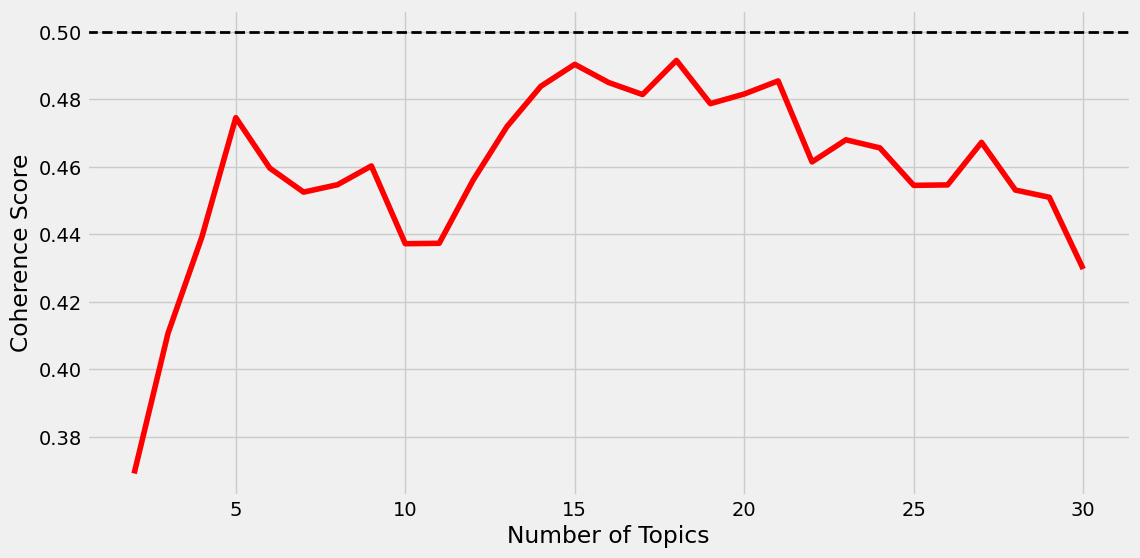

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2, 31, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.5, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

We choose the optimal number of topics as 15, based on our intuition and to see if we can get more new topics \ trends.

However you can experiment here and look at the models with lesser topics between 8 - 10.

Remember the scores are heuristics and not absolute like accuracy so try to look at the topics themselves instead of just relying blindly on the score (same as other unsupervised learning methods)

In [ ]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 15].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

15

In [ ]:
# you can also run your own model with 15 topics if needed
# although if you have already trained it earlier in the for loop
# just reuse it as shown in the code in the previous cell
# best_lda_model = gensim.models.LdaModel(corpus=bow_corpus,
#                                    id2word=dictionary,
#                                    chunksize=1740,
#                                    alpha='auto',
#                                    eta='auto',
#                                    random_state=42,
#                                    iterations=500,
#                                    num_topics=15,
#                                    passes=20,
#                                    eval_every=None)

### Topics from Best Model

In [ ]:
topics = [[(term, round(wt, 3))
               for term, wt in best_lda_model.show_topic(n, topn=20)]
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['neuron', 'cell', 'activity', 'response', 'spike', 'synaptic', 'pattern', 'stimulus', 'firing', 'connection', 'neural', 'synapsis', 'cortical', 'simulation', 'dynamic', 'effect', 'et_al', 'signal', 'frequency', 'phase']

Topic #2:
['circuit', 'chip', 'neuron', 'current', 'voltage', 'cell', 'motion', 'analog', 'signal', 'velocity', 'neural', 'implementation', 'response', 'design', 'array', 'synapse', 'device', 'bit', 'transistor', 'digital']

Topic #3:
['word', 'task', 'training', 'feature', 'object', 'view', 'user', 'human', 'representation', 'experiment', 'image', 'recognition', 'target', 'trained', 'position', 'prediction', 'similarity', 'sequence', 'frame', 'test']

Topic #4:
['training', 'class', 'classifier', 'classification', 'feature', 'test', 'training_set', 'pattern', 'prediction', 'vector', 'sample', 'experiment', 'kernel', 'machine', 'tree', 'estimate', 'linear', 'size', 'probability', 'regression']

Topic #5:
['probability', 'state', 'variable', 'mixture', 'hmm',

## Viewing LDA Model topics

In [ ]:
topics_df = pd.DataFrame([[term for term, wt in topic]
                              for topic in topics],
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15
Term1,neuron,circuit,word,training,probability,control,state,matrix,unit,signal,gaussian,image,state,let,image
Term2,cell,chip,task,class,state,trajectory,rule,signal,training,speech,distribution,unit,action,bound,visual
Term3,activity,neuron,training,classifier,variable,controller,node,vector,hidden_unit,face,noise,layer,policy,distribution,unit
Term4,response,current,feature,classification,mixture,movement,memory,noise,rate,frequency,vector,recognition,reinforcement_learning,approximation,map
Term5,spike,voltage,object,feature,hmm,robot,unit,source,vector,image,variance,training,step,theory,object
Term6,synaptic,cell,view,test,structure,position,vector,state,pattern,speaker,prior,feature,control,theorem,pattern
Term7,pattern,motion,user,training_set,cluster,motor,sequence,linear,node,sound,linear,character,optimal,class,feature
Term8,stimulus,analog,human,pattern,distribution,dynamic,pattern,component,back_propagation,detection,approximation,net,reward,probability,cell
Term9,firing,signal,representation,prediction,likelihood,state,neuron,nonlinear,layer,feature,image,pattern,environment,xi,stimulus
Term10,connection,velocity,experiment,vector,sequence,arm,recurrent,ica,gradient,representation,transformation,architecture,agent,optimal,layer


In [ ]:
pd.set_option('display.max_colwidth', None)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

,Terms per Topic
Topic1,"neuron, cell, activity, response, spike, synaptic, pattern, stimulus, firing, connection, neural, synapsis, cortical, simulation, dynamic, effect, et_al, signal, frequency, phase"
Topic2,"circuit, chip, neuron, current, voltage, cell, motion, analog, signal, velocity, neural, implementation, response, design, array, synapse, device, bit, transistor, digital"
Topic3,"word, task, training, feature, object, view, user, human, representation, experiment, image, recognition, target, trained, position, prediction, similarity, sequence, frame, test"
Topic4,"training, class, classifier, classification, feature, test, training_set, pattern, prediction, vector, sample, experiment, kernel, machine, tree, estimate, linear, size, probability, regression"
Topic5,"probability, state, variable, mixture, hmm, structure, cluster, distribution, likelihood, sequence, prior, clustering, step, node, component, tree, em, bayesian, graph, estimate"
Topic6,"control, trajectory, controller, movement, robot, position, motor, dynamic, state, arm, task, hand, forward, training, change, target, feedback, mapping, force, joint"
Topic7,"state, rule, node, memory, unit, vector, sequence, pattern, neuron, recurrent, net, matrix, bit, threshold, activation, size, dynamic, symbol, attractor, string"
Topic8,"matrix, signal, vector, noise, source, state, linear, component, nonlinear, ica, equation, rule, dynamic, density, filter, eq, pca, estimate, solution, estimation"
Topic9,"unit, training, hidden_unit, rate, vector, pattern, node, back_propagation, layer, gradient, activation, solution, architecture, simulation, step, equation, task, update, average, convergence"
Topic10,"signal, speech, face, frequency, image, speaker, sound, detection, feature, representation, channel, auditory, rate, subject, classification, training, recognition, frame, experiment, human"


## Interpreting Topic Model Results

An interesting point to remember is, given a corpus of documents (in the form of
features, e.g., Bag of Words) and a trained topic model, you can predict the distribution of
topics in each document (research paper in this case).

We can now get the most dominant topic per research paper with some intelligent
sorting and indexing.

In [ ]:
# Sample paper -> paper 3
print(papers[3][:1000])

674 
PATYEP CLASS DEGENERACY IN AN UNRESTRICTED STORAGE 
DENSITY MEMORY 
Christopher L. Scofield, Douglas L. Reilly, 
Charles Elbaum, Leon N. Cooper 
Nestor, Inc., 1 Richmond Square, Providence, Rhode Island, 
02906. 
ABSTRACT 
The study of distributed memory systems has produced a 
number of models which work well in limited domains. 
However, until recently, the application of such systems to real- 
world problems has been difficult because of storage limitations, 
and their inherent architectural (and for serial simulation, 
computational) complexity. Recent development of memories 
with unrestricted storage capacity and economical feedforward 
architectures has opened the way to the application of such 
systems to complex pattern recognition problems. However, 
such problems are sometimes underspecified by the features 
which describe the environment, and thus a significant portion 
of the pattern environment is often non-separable. We will 
review current work on high density memo

In [ ]:
print(bow_corpus[3][:30])

[(2, 1), (3, 3), (4, 1), (6, 3), (12, 5), (17, 4), (26, 1), (29, 1), (37, 1), (40, 8), (42, 1), (51, 1), (59, 2), (79, 2), (85, 8), (86, 1), (87, 1), (91, 1), (93, 11), (100, 2), (106, 1), (108, 2), (112, 1), (113, 1), (118, 2), (126, 1), (127, 3), (131, 1), (137, 2), (147, 2)]


In [ ]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[3][:30]])

[('ability', 1), ('able', 3), ('abstract', 1), ('acad_sci', 3), ('activity', 5), ('addition', 4), ('allowed', 1), ('american_institute', 1), ('another', 1), ('application', 8), ('approximate', 1), ('associative_memory', 1), ('basin_attraction', 2), ('called', 2), ('cell', 8), ('certain', 1), ('change', 1), ('chosen', 1), ('class', 11), ('collective', 2), ('compare', 1), ('complex', 2), ('composed', 1), ('computational', 1), ('condition', 2), ('consists', 1), ('constant', 3), ('continuous', 1), ('could', 2), ('define', 2)]


In [ ]:
# predict topic distribution for each paper
tm_results = best_lda_model[bow_corpus]

In [ ]:
# get top most relevant topic for each paper
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0]
                     for topics in tm_results]
corpus_topics[:5]

[(6, 0.64343506),
 (6, 0.45883563),
 (8, 0.9343698),
 (6, 0.4633554),
 (6, 0.47384953)]

In [ ]:
# check topic for paper 3 from above
corpus_topics[3]

(11, 0.29105332)

In [ ]:
# most relevant topic for paper 3
topics_df.iloc[corpus_topics[3][0]]

Terms per Topic    memory, layer, vector, bit, node, noise, signal, training, code, pattern, processor, application, architecture, back_propagation, feature, net, matrix, solution, connection, capacity
Name: Topic12, dtype: object

In [ ]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = [paper[:500] for paper in papers]

## Dominant Topics in Each Research Paper

Another interesting perspective is to select any paper, view the most dominant topic in each of those papers, and see if that makes sense.

In [ ]:
corpus_topic_df.head(10)

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
0,0,1,72.57,"unit, pattern, representation, rule, hidden_unit, word, net, activation, layer, training, character, structure, sequence, vector, task, connectionist, recognition, trained, architecture, level","5O5 \nCONNECTING TO THE PAST \nBruce A. MacDonald, Assistant Professor \nKnowledge Sciences Laboratory, Computer Science Department \nThe University of Calgary, 2500 University Drive NW \nCalgary,..."
1,1,1,51.39,"unit, pattern, representation, rule, hidden_unit, word, net, activation, layer, training, character, structure, sequence, vector, task, connectionist, recognition, trained, architecture, level","72 \nANALYSIS AND COMPARISON OF DIFFERENT LEARNING \nALGORITHMS FOR PATTERN ASSOCIATION PROBLEMS \nJ. Bernasconi \nBrown Boveri Research Center \nCH-5405 Baden, Switzerland \nABSTRACT \nWe investi..."
2,2,1,25.20,"unit, pattern, representation, rule, hidden_unit, word, net, activation, layer, training, character, structure, sequence, vector, task, connectionist, recognition, trained, architecture, level","310 \nPROBABILISTIC CHARACTERIZATION OF \nNEURAL MODEL COMPUTATIONS \nRichard M. Golden ' \nUniversity of Pittsburgh, Pittsburgh, Pa. 15260 \nABSTRACT \nInformation retrieval in a neural network ..."
3,3,12,29.11,"memory, layer, vector, bit, node, noise, signal, training, code, pattern, processor, application, architecture, back_propagation, feature, net, matrix, solution, connection, capacity","52 \nSupervised Learning of Probability Distributions \nby Neural Networks \nEric B. Baum \nJet Propulsion Laboratory, Pasadena CA 91109 \nFrank Wilczek \nDepartment of Physics,Harvard University..."
4,4,12,37.06,"memory, layer, vector, bit, node, noise, signal, training, code, pattern, processor, application, architecture, back_propagation, feature, net, matrix, solution, connection, capacity","397 \nAN OPTIMIZATION NETWORK FOR MATRIX INVERSION \nJu-Seog Jang, Soo-Young Lee, and Sang-Yung Shin \nKorea Advanced Institute of Science and Technology, \nP.O. Box 150, Cheongryang, Seoul, Korea..."
5,5,8,49.12,"neuron, spike, response, cell, signal, stimulus, frequency, firing, channel, neural, synaptic, rate, noise, activity, effect, pattern, temporal, threshold, firing_rate, et_al","402 \nHOW THE CATFISH TRACKS ITS PREY: AN INTERACTIVE ""PIPELINED"" \nPROCESSING SYSTEM MAY DIRECT FORAGING VIA RETICULOSPINAL NEURONS. \nJagmeet S. Kanwal \nDept. of Cellular & Structural Biology, ..."
6,6,12,83.33,"memory, layer, vector, bit, node, noise, signal, training, code, pattern, processor, application, architecture, back_propagation, feature, net, matrix, solution, connection, capacity","814 \nNEU1OMO1PHIC NETWORKS BASED \nON SPARSE OPTICAL ORTHOGONAL CODES \nMario P. Vecchi and Jawad A. Salehl \nBell Communications Research \n435 South Street \nMorristown, NJ 07960-1961 \nAbstr..."
7,7,8,65.48,"neuron, spike, response, cell, signal, stimulus, frequency, firing, channel, neural, synaptic, rate, noise, activity, effect, pattern, temporal, threshold, firing_rate, et_al","715 \nA COMPUTER SIMULATION OF CEREBRAL NEOCORTEX: \nCOMPUTATIONAL CAPABILITIES OF NONLINEAR NEURAL NETWORKS \nAlexander Singer* and John P. Donoghue** \n*Department of Biophysics, Johns Hopkins U..."
8,8,4,29.37,"state, action, control, policy, step, reinforcement_learning, controller, environment, optimal, task, robot, goal, reward, agent, trajectory, td, current, reinforcement, cost, trial","249 \nHIERARCHICAL LEARNING CONTROL - \nAN APPROACH WITH NEURON-LIKE ASSOCIATIVE MEMORIES \nE. Ers \nISRA Systemtechnik GmbH, Sch6fferstr. 15, D-6100 Darmstadt, FRG \nH. Tolle \nTH Darmstadt, Ins..."
9,9,4,83.71,"state, action, control, policy, step, reinforcement_learning, controller, environment, optimal, task, robot, goal, reward, agent, trajectory, td, current, reinforcement, cost, trial","642 \nLEARNING BY STATE RECURRENCE DETECFION \nBruce E. Rosen, James M. Goodwin*, and Jacques J. Vidal \nUniversity of California, Los An

## Inference on existing papers

In [ ]:
sample_paper_patterns = ['Feudal Reinforcement Learning \nPeter', 'Illumination-Invariant Face Recognition with a', 'Improved Hidden Markov Model Speech Recognition']
sample_paper_idxs = [idx for pattern in sample_paper_patterns
                            for idx, content in enumerate(papers)
                                if pattern in content]
sample_paper_idxs

[665, 790, 532]

In [ ]:
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document']
                 .isin(sample_paper_idxs)])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
532,532,7,79.48,"training, unit, speech, trained, word, feature, recognition, task, architecture, experiment, test, classification, table, speaker, node, class, mlp, hidden_unit, training_set, prediction","Improved Hidden Markov Model \nSpeech Recognition Using \nRadial Basis Function Networks \nElliot Singer and Richard P. Lippmann \nLincoln Laboratory, MIT \nLexington, MA 02173-9108, USA \nAbstrac..."
665,665,4,86.31,"state, action, control, policy, step, reinforcement_learning, controller, environment, optimal, task, robot, goal, reward, agent, trajectory, td, current, reinforcement, cost, trial","Feudal Reinforcement Learning \nPeter Dayan \nCNL \nThe Salk Institute \nPO Box 85800 \nSan Diego CA 92186-5800, USA \ndayanhelmholtz. sdsc. edu \nGeoffrey E Hinton \nDepartment of Computer Scien..."
790,790,2,66.40,"image, object, feature, pixel, face, view, visual, representation, recognition, region, task, surface, location, local, position, shape, training, filter, scene, motion","Illumination-Invariant Face Recognition with a \nContrast Sensitive Silicon Retina \nJoachim M. Buhmann \nRheinische Friedrich-Wilhelms-Universitfit \nInstitut ftir Informatik II, R6merstrage 164 ..."


## Topic Inference on New Papers (Data)

In [ ]:
new_paper = """
Efficient Visual Recognition with Deep Neural Networks: A Survey on Recent Advances and New Directions
Yang Wu, Dingheng Wang, Xiaotong Lu, Fan Yang, Guoqi Li, Weisheng Dong, Jianbo Shi
Visual recognition is currently one of the most important and active research areas in computer vision,
pattern recognition, and even the general field of artificial intelligence.
It has great fundamental importance and strong industrial needs.
Deep neural networks (DNNs) have largely boosted their performances on many concrete tasks,
with the help of large amounts of training data and new powerful computation resources.
Though recognition accuracy is usually the first concern for new progresses,
efficiency is actually rather important and sometimes critical for both academic research
and industrial applications. Moreover, insightful views on the opportunities and challenges
of efficiency are also highly required for the entire community.
While general surveys on the efficiency issue of DNNs have been done from various perspectives,
as far as we are aware, scarcely any of them focused on visual recognition systematically,
and thus it is unclear which progresses are applicable to it and what else should be concerned.
In this paper, we present the review of the recent advances with our suggestions on the new
possible directions towards improving the efficiency of DNN-related visual recognition approaches.
We investigate not only from the model but also the data point of view
(which is not the case in existing surveys), and focus on three most studied
data types (images, videos and points). This paper attempts to provide a systematic summary
via a comprehensive survey which can serve as a valuable reference and inspire both researchers
and practitioners who work on visual recognition problems.
"""

new_paper

'\nEfficient Visual Recognition with Deep Neural Networks: A Survey on Recent Advances and New Directions\nYang Wu, Dingheng Wang, Xiaotong Lu, Fan Yang, Guoqi Li, Weisheng Dong, Jianbo Shi\nVisual recognition is currently one of the most important and active research areas in computer vision, \npattern recognition, and even the general field of artificial intelligence. \nIt has great fundamental importance and strong industrial needs. \nDeep neural networks (DNNs) have largely boosted their performances on many concrete tasks, \nwith the help of large amounts of training data and new powerful computation resources. \nThough recognition accuracy is usually the first concern for new progresses, \nefficiency is actually rather important and sometimes critical for both academic research \nand industrial applications. Moreover, insightful views on the opportunities and challenges \nof efficiency are also highly required for the entire community. \nWhile general surveys on the efficiency is

## Pre-process Text

In [ ]:
import tqdm

In [ ]:
preprocessed_papers = normalize_corpus([new_paper])
print(preprocessed_papers[0][:30])

100%|██████████| 1/1 [00:00<00:00, 143.82it/s]

['efficient', 'visual', 'recognition', 'deep', 'neural', 'network', 'survey', 'recent', 'advance', 'new', 'direction', 'yang', 'wu', 'dingheng', 'wang', 'xiaotong', 'lu', 'fan', 'yang', 'guoqi', 'li', 'weisheng', 'dong', 'jianbo', 'shi', 'visual', 'recognition', 'currently', 'one', 'important']


## Generate Influential Bi-grams if any

In [ ]:
bigrams_corpus = [bigram_model[doc] for doc in preprocessed_papers]
print(bigrams_corpus[0][0:30])

['efficient', 'visual', 'recognition', 'deep', 'neural_network', 'survey', 'recent', 'advance', 'new', 'direction', 'yang', 'wu', 'dingheng', 'wang', 'xiaotong', 'lu', 'fan', 'yang', 'guoqi', 'li', 'weisheng', 'dong', 'jianbo', 'shi', 'visual', 'recognition', 'currently', 'one', 'important', 'active']


## Generate BOW Vectors from Training Vectorizer

In [ ]:
bow_corpus = [dictionary.doc2bow(text) for text in bigrams_corpus]
print(bow_corpus[0][:30])

[(19, 1), (40, 1), (44, 1), (46, 1), (91, 1), (117, 1), (237, 1), (279, 1), (295, 2), (316, 1), (387, 1), (417, 1), (473, 2), (492, 2), (512, 1), (515, 2), (579, 1), (586, 1), (595, 1), (602, 1), (612, 1), (617, 1), (634, 1), (637, 2), (663, 1), (739, 1), (758, 1), (766, 1), (843, 1), (892, 1)]


## Use trained topic model to predict topics

In [ ]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[0][:30]])

[('active', 1), ('application', 1), ('area', 1), ('artificial_intelligence', 1), ('challenge', 1), ('computation', 1), ('far', 1), ('highly', 1), ('important', 2), ('investigate', 1), ('need', 1), ('paper_present', 1), ('progress', 2), ('recent', 2), ('required', 1), ('research', 2), ('strong', 1), ('suggestion', 1), ('task', 1), ('though', 1), ('training', 1), ('type', 1), ('various', 1), ('view', 2), ('actually', 1), ('critical', 1), ('else', 1), ('even', 1), ('moreover', 1), ('rather', 1)]


## Show most relevant topic

In [ ]:
predicted_topics = best_lda_model[bow_corpus][0]
predicted_topics

[(1, 0.5862816), (6, 0.272409), (11, 0.1375469)]

In [ ]:
top_topic = max(predicted_topics, key=lambda x: x[1])
top_topic

(1, 0.5862816)

In [ ]:
top_topic_idx = top_topic[0]
top_topic_idx

1

In [ ]:
topics_df.iloc[[top_topic_idx]]

,Terms per Topic
Topic2,"image, object, feature, pixel, face, view, visual, representation, recognition, region, task, surface, location, local, position, shape, training, filter, scene, motion"


Looking at the paper abstract our topic model did pretty well in predicting a very relevant topic for the paper

In [ ]:
print(new_paper)


Efficient Visual Recognition with Deep Neural Networks: A Survey on Recent Advances and New Directions
Yang Wu, Dingheng Wang, Xiaotong Lu, Fan Yang, Guoqi Li, Weisheng Dong, Jianbo Shi
Visual recognition is currently one of the most important and active research areas in computer vision, 
pattern recognition, and even the general field of artificial intelligence. 
It has great fundamental importance and strong industrial needs. 
Deep neural networks (DNNs) have largely boosted their performances on many concrete tasks, 
with the help of large amounts of training data and new powerful computation resources. 
Though recognition accuracy is usually the first concern for new progresses, 
efficiency is actually rather important and sometimes critical for both academic research 
and industrial applications. Moreover, insightful views on the opportunities and challenges 
of efficiency are also highly required for the entire community. 
While general surveys on the efficiency issue of DNNs h